# Activity Prediction for Chemical Compounds

This is my implementation of using a Random Forest classifier to do activity prediction on chemical compunds dataset.
i.e. given a chemical compound in SMILES format the target is to output whether the chemical compound is active (=1) or inactive (=0).

## Dataset

For training the model we will use a subset of the [Tox21 data](https://tripod.nih.gov/tox21/challenge/). The data was released as part of a challenge in data analysis by to reveal how well they can predict compounds' interference in biochemical pathways using only chemical structure data. In this project we will use a subset of the data that consists of 19,125 chemical compounds represented bySMILES together with their activity label (0 = inactive, 1 =active).

Once you download the dataset, it contains 2 folders: pos and neg.

<img src="images/dataset folder.png" width="200px" />

The folder name indicate the true sentiment of the files inside. Each folder contains an excel files.

## Loading the Training Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

In [5]:
#loading data
smiles_df = pd.read_csv("data/training_smiles.csv")
X = smiles_df['SMILES'].to_numpy()
y = smiles_df['ACTIVE'].to_numpy()

In [7]:
# shape of data
X.shape

(19125,)

Each chemical compound is stored in SMILES format. we will use ```RDKit``` [package](https://www.rdkit.org/) to parse the SMILES format and extract relevant features for each chmecial compound to use for training the model.

In [8]:
from rdkit import Chem
import rdkit.Chem.rdMolDescriptors as d
import rdkit.Chem.Fragments as f
import rdkit.Chem.Lipinski as l
from rdkit.Chem import AllChem

RDKit WARNING: [11:21:37] Enabling RDKit 2019.09.1 jupyter extensions


## Data Distribution

we can plot a histogram to see the distribution of the data

<BarContainer object of 1 artists>

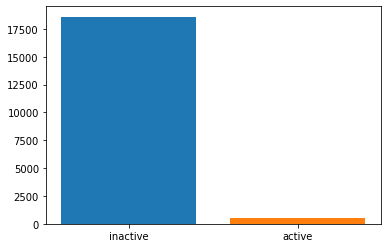

In [20]:
classes, counts = np.unique(y, return_counts=True)
classes = ['active' if c == 1 else 'inactive' for c in classes]
plt.bar(classes[0], counts[0])
plt.bar(classes[1], counts[1])

## Train/Test Split

At this point, it is a good idea to split the data into training data and testing data where the former is used in training the model while the later is used to evaluate its performance on unseen data before deploying it into a production environment.

Since the distribution of the active/inative is skewed it is better to use a Stratified Shuffle Split to make sure the percentage of each class is preserved.

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [22]:
# split data into a train data set and test data for final evaluation
# test data 0.2%,  training and hyperparameter tuning 0.8%
train_test_spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_index, test_index = next(train_test_spliter.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [24]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (15300,)
X_test shape: (3825,)
y_train shape: (15300,)
y_test shape: (3825,)


## Feature Extraction

we will generate 114 features from rdMolDescriptors , Fragments , and Lipinski modules. We will use functions that return a numeric value. Below is a summary of number of functions used per module.

Module|Number of functions|Usage
:----------|:--------------:|:-----
rdMolDescriptors |42| Compute molecular descriptors
Fragments |85 |Compute fragments descriptors
Lipinski |17| Compute Lipinski parameters

In [25]:
# generate features from rdMolDescriptors (42 features), Lipinski (17 features) and fragments (85 features)

X_moldesc_train = np.zeros((len(X_train), 144))
molecules_train = [Chem.MolFromSmiles(s) for s in X_train]

X_moldesc_test = np.zeros((len(X_test), 144))
molecules_test = [Chem.MolFromSmiles(s) for s in X_test]

for source, target in zip([molecules_train, molecules_test], [X_moldesc_train,  X_moldesc_test]):
    for idx, m in enumerate(source):
        target[idx] = [
                        #rdMolDescriptors - 42 features
                        d.CalcChi0n(m),
                        d.CalcChi0v(m),
                        d.CalcChi1n(m),
                        d.CalcChi1v(m),
                        d.CalcChi2n(m),
                        d.CalcChi2v(m),
                        d.CalcChi3n(m),
                        d.CalcChi3v(m),
                        d.CalcChi4n(m),
                        d.CalcChi4v(m),
                        d.CalcCrippenDescriptors(m)[0],
                        d.CalcCrippenDescriptors(m)[1],
                        d.CalcExactMolWt(m),
                        d.CalcFractionCSP3(m),
                        d.CalcHallKierAlpha(m),
                        d.CalcKappa1(m),
                        d.CalcKappa2(m),
                        d.CalcKappa3(m),
                        d.CalcLabuteASA(m),
                        d.CalcNumAliphaticCarbocycles(m),
                        d.CalcNumAliphaticHeterocycles(m),
                        d.CalcNumAliphaticRings(m),
                        d.CalcNumAmideBonds(m),
                        d.CalcNumAromaticCarbocycles(m),
                        d.CalcNumAromaticHeterocycles(m),
                        d.CalcNumAromaticRings(m),
                        d.CalcNumAtomStereoCenters(m),
                        d.CalcNumBridgeheadAtoms(m),
                        d.CalcNumHBA(m),
                        d.CalcNumHBD(m),
                        d.CalcNumHeteroatoms(m),
                        d.CalcNumHeterocycles(m),
                        d.CalcNumLipinskiHBA(m),
                        d.CalcNumLipinskiHBD(m),
                        d.CalcNumRings(m),
                        d.CalcNumRotatableBonds(m),
                        d.CalcNumSaturatedCarbocycles(m),
                        d.CalcNumSaturatedHeterocycles(m),
                        d.CalcNumSaturatedRings(m),
                        d.CalcNumSpiroAtoms(m),
                        d.CalcNumUnspecifiedAtomStereoCenters(m),
                        d.CalcTPSA(m),

                        # Lipinski - 17 features
                        l.FractionCSP3(m),
                        l.HeavyAtomCount(m),
                        l.NHOHCount(m),
                        l.NOCount(m),
                        l.NumAliphaticCarbocycles(m),
                        l.NumAliphaticHeterocycles(m),
                        l.NumAliphaticRings(m),
                        l.NumAromaticCarbocycles(m),
                        l.NumAromaticHeterocycles(m),
                        l.NumAromaticRings(m),
                        l.NumHAcceptors(m),
                        l.NumHDonors(m),
                        l.NumHeteroatoms(m),
                        l.NumRotatableBonds(m),
                        l.NumSaturatedCarbocycles(m),
                        l.NumSaturatedHeterocycles(m),
                        l.NumSaturatedRings(m),

                        # fragments  85 features
                        f.fr_Al_COO(m),
                        f.fr_Al_OH(m),
                        f.fr_Al_OH_noTert(m),
                        f.fr_ArN(m),
                        f.fr_Ar_COO(m),
                        f.fr_Ar_N(m),
                        f.fr_Ar_NH(m),
                        f.fr_Ar_OH(m),
                        f.fr_COO(m),
                        f.fr_COO2(m),
                        f.fr_C_O(m),
                        f.fr_C_O_noCOO(m),
                        f.fr_C_S(m),
                        f.fr_HOCCN(m),
                        f.fr_Imine(m),
                        f.fr_NH0(m),
                        f.fr_NH1(m),
                        f.fr_NH2(m),
                        f.fr_N_O(m),
                        f.fr_Ndealkylation1(m),
                        f.fr_Ndealkylation2(m),
                        f.fr_Nhpyrrole(m),
                        f.fr_SH(m),
                        f.fr_aldehyde(m),
                        f.fr_alkyl_carbamate(m),
                        f.fr_alkyl_halide(m),
                        f.fr_allylic_oxid(m),
                        f.fr_amide(m),
                        f.fr_amidine(m),
                        f.fr_aniline(m),
                        f.fr_aryl_methyl(m),
                        f.fr_azide(m),
                        f.fr_azo(m),
                        f.fr_barbitur(m),
                        f.fr_benzene(m),
                        f.fr_benzodiazepine(m),
                        f.fr_bicyclic(m),
                        f.fr_diazo(m),
                        f.fr_dihydropyridine(m),
                        f.fr_epoxide(m),
                        f.fr_ester(m),
                        f.fr_ether(m),
                        f.fr_furan(m),
                        f.fr_guanido(m),
                        f.fr_halogen(m),
                        f.fr_hdrzine(m),
                        f.fr_hdrzone(m),
                        f.fr_imidazole(m),
                        f.fr_imide(m),
                        f.fr_isocyan(m),
                        f.fr_isothiocyan(m),
                        f.fr_ketone(m),
                        f.fr_ketone_Topliss(m),
                        f.fr_lactam(m),
                        f.fr_lactone(m),
                        f.fr_methoxy(m),
                        f.fr_morpholine(m),
                        f.fr_nitrile(m),
                        f.fr_nitro(m),
                        f.fr_nitro_arom(m),
                        f.fr_nitro_arom_nonortho(m),
                        f.fr_nitroso(m),
                        f.fr_oxazole(m),
                        f.fr_oxime(m),
                        f.fr_para_hydroxylation(m),
                        f.fr_phenol(m),
                        f.fr_phenol_noOrthoHbond(m),
                        f.fr_phos_acid(m),
                        f.fr_phos_ester(m),
                        f.fr_piperdine(m),
                        f.fr_piperzine(m),
                        f.fr_priamide(m),
                        f.fr_prisulfonamd(m),
                        f.fr_pyridine(m),
                        f.fr_quatN(m),
                        f.fr_sulfide(m),
                        f.fr_sulfonamd(m),
                        f.fr_sulfone(m),
                        f.fr_term_acetylene(m),
                        f.fr_tetrazole(m),
                        f.fr_thiazole(m),
                        f.fr_thiocyan(m),
                        f.fr_thiophene(m),
                        f.fr_unbrch_alkane(m),
                        f.fr_urea(m)
                        ]

## Building the Model

We will use a random forest classifier and will use hyperparameter turing using grid search to find the best hyperparamters for the random forest. Below is a summary of the parameters that we will use in the search.

|Hyperparameter |Value Range
:----------|:---------------:|
Maximum Depth per tree| [1, 5, 11, 21, None]
Split Evaluation function |[Entropy, Gini Impurity]
Minimum Sample Split| [2, 5, 10]

We will split the training data into K folds, and for each combination of the hyperparameters, the model is trained on K-1 folds of the data and evaluated on a holdout set for all possible sections of the holdout set, and the model score is the average value across the K folds.